# Machine Learning Project: Amazon Kindle Book Review Sentiment Analysis
#### Author: Grishma Bhattarai

**Background:** Sentiment analysis is contextual mining of text which identifies and extracts subjective information in source material. Such sentiment analysis from text sources like reviews, tweets etc. can give us important and interesting insights about what people are talking about, the sentiments of people, their opinions towards a particular topic/brand and the general trends in society. 

<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/08/Sentiment-Analysis-scaled.jpg" width="700" height="350">


**Context:** This project is a sentiment analysis ML project on Amazon Kindle book reviews. The source for these reviews is a massive data repository that contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.

Our goal from this project is to extract insights from these reviews, which are a rich source of data, in order to better understand current climate within the book industry and see what types of books are highly consumed. The relevance of this project, for businesses and individuals alike, cannot be denied. Individuals can use results from this analysis to further enrich their book collection with books that the majority love. If public sentiment towards a book is not so good, they may also decide to avoid such books. Additionally, local bookstores and vendors can use such analysis to understand general demand and offer good products. Thus, sentiment analysis can help people in their decision-making process. 

**Task:** To train a **Binary Classification Model** to predict whether an Amazon Kindle book review is positive or non-positive based on the contents of the review. Each row in the data is an instance of a person's review related to a book.  

*Source: http://jmcauley.ucsd.edu/data/amazon/*




## Libraries

In [13]:
import time, os

# scientific calculation packages
import numpy as np 
import pandas as pd 
from collections import Counter

# visualization packages
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px

# machine learning packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc

# text preprocessing packages
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
from tqdm import tqdm
import re, string
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Attributes
1. *Unnamed 0* : id variable
2. *rating* : ordinal categorical variable [range 1-5]
3. *reviewText* : character variable-- Actual Book Review
4. *summary* : character variable-- summary of the review, analogous to a title

## Exploratory Data Analysis & Data Preprocessing


In [14]:
# read data
df = pd.read_csv('preprocessed_kindle_review .csv')

# check description and non-null value count on each feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12000 non-null  int64 
 1   rating      12000 non-null  int64 
 2   reviewText  12000 non-null  object
 3   summary     12000 non-null  object
dtypes: int64(2), object(2)
memory usage: 375.1+ KB


In [15]:
# check the data size and display the top-5 data samples 
df.shape, display(df.head(2))

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!


((12000, 4), None)

We create a new variable 'review' that combines the summary and the review text into one variable, because both are important to us. Then, we look at the distribution of ratings in our data.

In [16]:
df['review'] = df['summary'] + ' ' + df['reviewText']

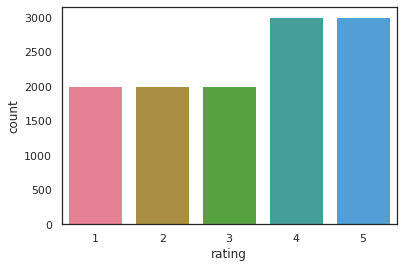

In [17]:
# look at the distribution of ratings in the data
sns.set_theme(style='white', palette='husl')
sns.countplot(x="rating", data=df)

Since our reviews are ordinal, we now map them into three types of sentiments with the rubric given below:

 - Positive: Rating > 3
 - Neutral: Rating == 3
 - Negative: Rating < 3

We also check for any duplicate reviews:

In [18]:
# map the ordered 'rating' variable into a new multiclass sentiment variable 
df.loc[df['rating'] == 3,'sentiment'] = 'Neutral'
df.loc[df['rating'] < 3,'sentiment'] = 'Negative'
df.loc[df['rating'] > 3,'sentiment'] = 'Positive'

In [19]:
# drop unnecessary columns
df = df.drop(['Unnamed: 0', 'summary','reviewText'],axis=1)

#### Balancing and Distribution


We perform a balance test for our target variable:

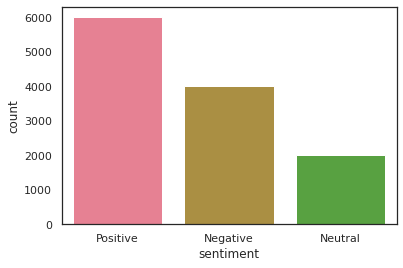

In [20]:
sns.countplot(x="sentiment", data=df)

We notice that the data is imbalanced. The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important. Hence, it needs to be balanced across sentiments. 

One approach to addressing imbalanced datasets is to merge our minority classes into one. Hence, we are going to change sentiments *Neutral* and *Negative* into a new sentiment *Non-Negative*. 

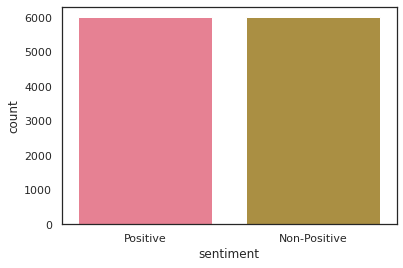

In [21]:
df['sentiment'] = df['sentiment'].replace(['Negative'],'Non-Positive') 
df['sentiment'] = df['sentiment'].replace(['Neutral'],'Non-Positive') 
sns.countplot(x="sentiment", data=df)

Our classes are balanced-- hence, this is a Binary Classification problem.

Now, we look at one example for each type of sentiment (positive & non-positive) to get a better understanding of the data:

In [22]:
# explore types of review
a, b = df.iloc[11995].sentiment, df.iloc[11995].review
c, d = df.iloc[11997].sentiment, df.iloc[11997].review
data = [[a, b], [c, d]]
df_explore = pd.DataFrame(data, columns = ['Sentiment', 'Review'])
pd.set_option('display.max_colwidth', None)
df_explore

,Sentiment,Review
0,Non-Positive,Where's the meat? Had to read certain passages twice--typos. Wish there had been more on how they built up to a relationship. I felt no chemistry between these two.
1,Positive,"Dragon Knights, Wings of Change (I Dream of Dragons I) Dragon Knights is a world where Knights ride dragons and not slay them. Wings of Change (I Dream of Dragons I) is a Novella that can be read before FireDrake or after. It give some backgroung and insite into Helos and the Gryphons. It does not advance the story line but does enhance it. Another enjoyable read in the Dragon Knight relm."


In [23]:
# check for duplicated instances and remove if any
duplicate = df['review'].duplicated().any()
duplicate

False

In [24]:
df['length'] = df['review'].apply(len) # number of characters
df['length'].describe() 
# the describe function shows the mean, std, min, max of length of the reviews

count    12000.000000
mean       624.788750
std        714.566391
min         18.000000
25%        190.000000
50%        354.000000
75%        765.000000
max      12286.000000
Name: length, dtype: float64

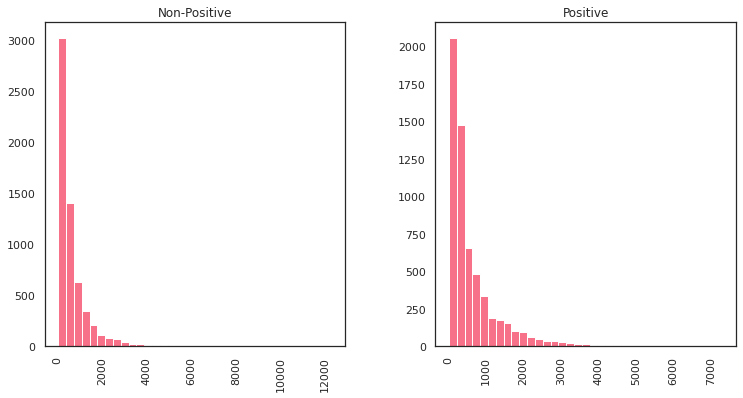

In [25]:
# plot the length of positive and negative reviews
# x: length of reviews; y: number of reviews fall into each interval
df.hist(column='length', by='sentiment',bins=35, figsize=(12,6))
plt.show()
# adding xlabel, ylabel, title

According to the above distribution, there is no clear difference in the two types of reviews in terms of review length. Now, after the initial exploration, we have a basic understanding of the dataset and can go ahead to process the reviews.

#### Deconstruction & Cleaning

In [26]:
def decontracted(phrase):
    """
    Expand the contracted phrase into normal words
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) # prime 
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_review = []

    for review_text in tqdm(df['review']):
        
        # expand the contracted words
        review_text = decontracted(review_text)

        #  remove all '\n' in the string and replace it with a space
        remove_text = re.sub("\n", " ", review_text)
        
        # remove html tags <br> <html>
        review_text = BeautifulSoup(review_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
        
        # remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        # remove urls
        review_text = re.sub(r'https?://\S+|www\.\S+', '', review_text)
        
        # remove punctutation [string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~` ] 
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))
        
        # remove emails
        review_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', review_text)
    
        cleaned_review.append(review_text)

    return cleaned_review

df['cleaned_review'] = clean_text(df)

100%|██████████| 12000/12000 [00:05<00:00, 2370.63it/s]


In [27]:
df.iloc[11995].review, df.iloc[11995].cleaned_review

("Where's the meat? Had to read certain passages twice--typos.  Wish there had been more on how they built up to a relationship.  I felt no chemistry between these two.",
 'Where is the meat  Had to read certain passages twice  typos   Wish there had been more on how they built up to a relationship   I felt no chemistry between these two ')

In [28]:
df = df.drop(['review'],axis=1)

#### Wordclouds

In [29]:
# seperate dataframes for each sentiment for convenience
Positive = df.loc[df['sentiment'] == 'Positive']
NPositive = df.loc[df['sentiment'] == 'Non-Positive']

- Positive:

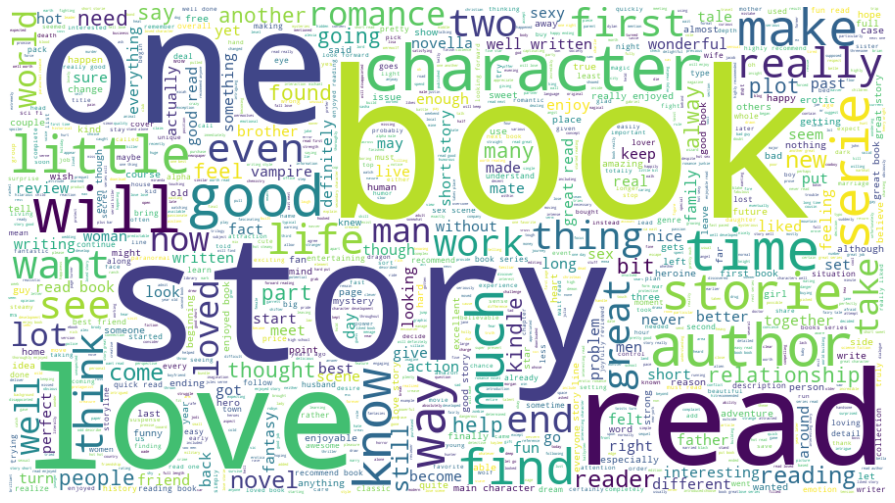

In [30]:
# define a function to produce a wordcloud
def wc(data):
    plt.figure(figsize = (16,9))
    wc = WordCloud(background_color = 'white', max_words = 10000, width=900, height=500)
    wc.generate(data)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')

text_pos = ' '.join(Positive['cleaned_review']).lower()
wc(text_pos)

- Non-Positve:

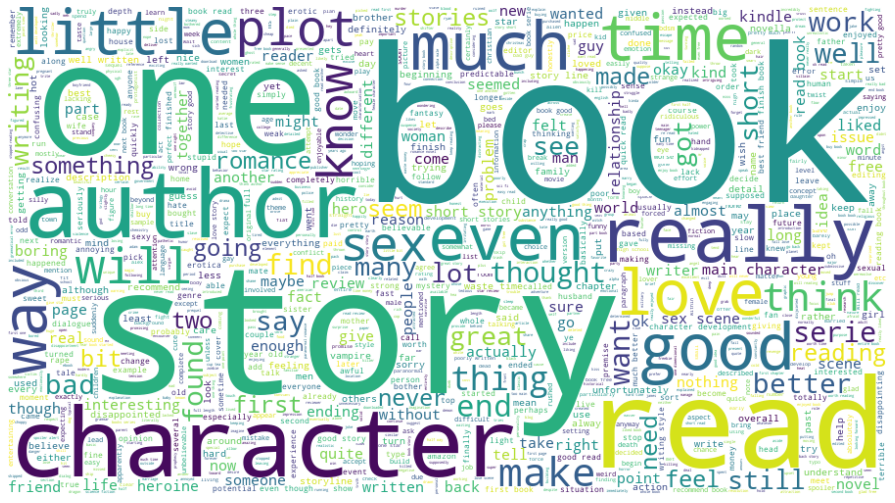

In [31]:
text_neu = ' '.join(NPositive['cleaned_review']).lower()
wc(text_neu)

We look at word clouds for both labels to see if any word stands out. Wordclouds are basically visualization of words present in each of our label where their sizes represent the frequency in our data. As we can see from above, words like love are frequently used in positive class and even though we see them in negative class, the frequency is fairly smaller. This is a good tool in understanding our data better.


#### N-grams

Now, we remove necessary stopwords and proceed to look at N-grams frequency distributions for unigrams, bigrams and trigrams:


In [32]:
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: ' '.join([corpus for corpus in x.split() if corpus not in stopwords]))

In [33]:
 #construct a n-gram frequency plot function
def get_top_nwords(x, n, i, c):
    vec = CountVectorizer(ngram_range=(i,i)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
    topn =  words_freq[:n]
    df = pd.DataFrame(topn, columns=['N-gram', 'Frequency'])
    fig = plt.figure(figsize=(8,4))
    plt.bar(df['N-gram'], df['Frequency'], color=c)
    plt.xticks(rotation = 90)
    plt.show()

- Unigrams

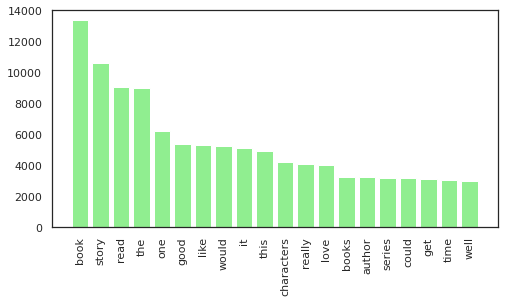

In [34]:
get_top_nwords(df['cleaned_review'], 20, 1, 'lightgreen') 

- Bigrams

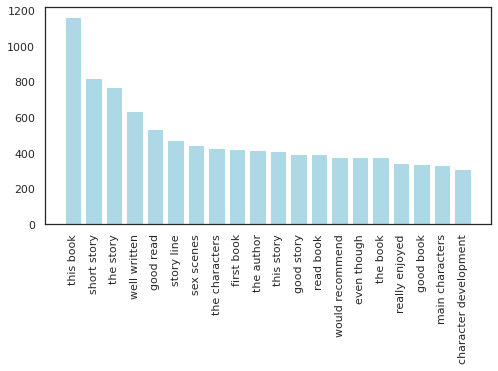

In [35]:
get_top_nwords(df['cleaned_review'], 20, 2, 'lightblue') 

- Trigrams

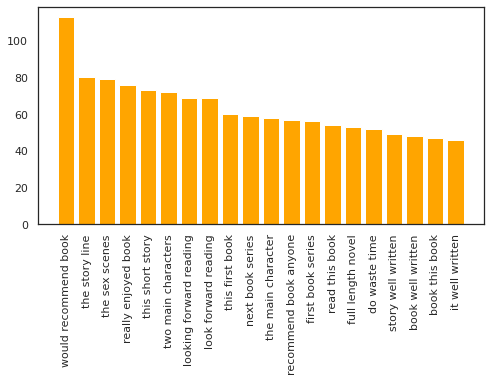

In [36]:
get_top_nwords(df['cleaned_review'], 20, 3, 'orange') 

We see that bigrams give us more information into the type of sentiment than unigrams, and trigrams do not give added information. This is a good insight and will be used during our parameter tuning. After exploring the data and understanding its intricacies a bit more, we remove unnecessary columns from our analysis for convenience and finally encode our target variable *sentiment*:

In [37]:
df['label'] = df['sentiment'].map({'Non-Positive':0,'Positive':1})
df.head(2)

,rating,sentiment,length,cleaned_review,label
0,5,Positive,316,years ago This book first bookmobile book I bought I school book club I loved story I bet dollar donut I love If memory serves I bought book th grade That would I looking forward reliving memories,1
1,1,Non-Positive,2101,Boring Boring Boring When I read description book I could wait read Once I downloaded Kindle I found extremely hard keep reading To honest I stopped reading halfway book It began slow remained slow uninteresting read It lacked passion making love passion passion life Neither Jada Aaron interesting characters story everything perfect Everybody understanding accommodating bit drama father grandmother blah To give example I mean MANY Aaron finally finds almost half way book fathered child years ago keep mind Aaron Jada kept contact months left never mentioned pregnant When finally tells son Aaron becomes overwhelmed emotions misty eyed knowing father WTH I think men would upset angry know child woman love never told Not book good well NO PASSION OMG let get started scene father son finally meet It top made want barf Maybe scene towards beginning book would touching In middle book much blah made thrown kindle It like eating sweet dessert sweet made teeth hurt This book good theme follow Also believe Jada graduated Harvard let reflected speech job We told wonderful personality caused Aaron fall love never saw If author described depressed foolish Yes I would believe heartbeat She boring This book frustrating read I truly struggled read far I I finally stopped torturing I realized going get better,0


## Pipeline: Feature Selection, Parameter Tuning and Data Validation [Grid Search CV]

Now, we proceed to create pipelines in order to choose the best parameters for feature selection and model selection. 

First, however, we shuffle the data with random permutations of the collection and split the data into training and testing sets by 70:30 ratio in order to prevent knowledge leakage from test dataset during the process of Grid Search CV.

In [38]:
X = df ['cleaned_review']
y = df ['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                 shuffle=True,
                                                 random_state=42)
# check data size after splitting
print("Training data: X : {}, y : {}".format(X_train.shape, y_train.shape))
print("Testing data: X : {}, y : {}".format(X_test.shape, y_test.shape))

Training data: X : (8400,), y : (8400,)
Testing data: X : (3600,), y : (3600,)


In [39]:
# check data distribution in train and test
print("Training data distribution", Counter(y_train))
print("Testing data distribution", Counter(y_test))

Training data distribution Counter({1: 4240, 0: 4160})
Testing data distribution Counter({0: 1840, 1: 1760})


After the train-test split, we have 8400 samples in the training set and 3600 samples in the testing set. Our classes 1: *Positive* and 0: *Non-Positive* are fairly balanced and proportional in the training and testing set.

Now we create encapsulated pipelines for parameter tuning of feature selection and model selection. We use a Grid Search CV with a 5-fold data validation step to pick the best parameters. 

1. Grid Search CV Pipeline for CountVectorizer with Logistic Regression

In [40]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords)
tfidf = TfidfTransformer()
logistic = LogisticRegression() 

# set the pipeline
log = Pipeline(steps = [
       ('vectorizer', vectorizer),
       ('tfidf', tfidf),
       ('classifier', logistic)])


# pick parameters
log_grid = {
    'vectorizer__min_df': [1, 3, 5],
    'vectorizer__max_df': [0.8, 0.9],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'classifier__penalty': ['l1','l2']}

In [41]:
# run grid search cv:
log_search_result = GridSearchCV(log, log_grid, cv=5, scoring='f1').fit(X_train, y_train)

In [42]:
print("Best parameter for Logistic Regression Pipeline (CV score=%0.3f):" % log_search_result.best_score_) 
print(log_search_result.best_params_)

Best parameter for Logistic Regression Pipeline (CV score=0.853):
{'classifier__penalty': 'l2', 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2)}


2. Grid Search CV Pipeline for CountVectorizer with Multinomial Naive Bayes Classifier

In [43]:
nbayes = MultinomialNB()

# set the pipeline
nb = Pipeline(steps = [
       ('vectorizer', vectorizer),
       ('classifier', nbayes)])

# pick parameters
nb_grid = {
    'vectorizer__min_df': [1, 3, 5],
    'vectorizer__max_df': [0.8, 0.9],
    'vectorizer__ngram_range': [(1,1), (1,2)]}

In [44]:
# run grid search cv:
nb_search_result = GridSearchCV(nb, nb_grid, cv=5, scoring='f1').fit(X_train, y_train)

In [45]:
print("Best parameter for Multinomial NB Pipeline (CV score=%0.3f):" % nb_search_result.best_score_) 
print(nb_search_result.best_params_)

Best parameter for Multinomial NB Pipeline (CV score=0.852):
{'vectorizer__max_df': 0.8, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}


3. Grid Search CV Pipeline for CountVectorizer with Support Vector Machine Classifier w/ stochastic gradient descent training

In [46]:
svm_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

# set the pipeline
svm = Pipeline([('vectorizer', vectorizer),
                ('tfidf', tfidf),
                ('classifier', svm_sgd)])

# pick parameters
svm_grid = {
    'vectorizer__min_df': [1, 3, 5],
    'vectorizer__max_df': [0.8, 0.9],
    'vectorizer__ngram_range': [(1,1), (1,2)]}

In [47]:
# run grid search cv:
svm_search_result = GridSearchCV(svm, svm_grid, cv=5, scoring='f1').fit(X_train, y_train)

In [48]:
print("Best parameter for Support Vector Machine Pipeline (CV score=%0.3f):" % svm_search_result.best_score_) 
print(svm_search_result.best_params_)

Best parameter for Support Vector Machine Pipeline (CV score=0.850):
{'vectorizer__max_df': 0.8, 'vectorizer__min_df': 5, 'vectorizer__ngram_range': (1, 2)}


We have completed Grid Search 5-fold CV Pipeline for our 3 models and picked the following parameters:

1. **Logistic Regression Classification:**
+ 'classifier__penalty': 'l2'
+ 'vectorizer__max_df': 0.8
+ 'vectorizer__min_df': 3
+ 'vectorizer__ngram_range': (1, 2)
2. **Multinomial Naive Bayes Classification:**
+ 'vectorizer__max_df': 0.8
+ 'vectorizer__min_df': 1
+ 'vectorizer__ngram_range': (1, 2)
3. **Support Vector Machine Classification:**
+ 'vectorizer__max_df': 0.8
+ 'vectorizer__min_df': 5
+ 'vectorizer__ngram_range': (1, 2)

## Model Training (Training Set), Model Evaluation (On Testing Set) & Error Analysis

### Logistic Regression Classifier

First we fit CountVectorizer on entire data for more robust vocabulary, then transform them to both train and test set. We then transform both of them to tf-idf representation. Finally, we train our classifier model and make predictions on our test set. 

In [49]:
log_vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords, max_df=0.8, min_df=3, ngram_range=(1,2))
log_fit = log_vectorizer.fit(X)
log_X_train = log_fit.transform(X_train)
log_X_test = log_fit.transform(X_test)
log_X_train = tfidf.fit_transform(log_X_train)
log_X_test = tfidf.transform(log_X_test)

In [50]:
log_clf = LogisticRegression(penalty='l2')
log_clf.fit(log_X_train, y_train)

LogisticRegression()

In [51]:
# make prediction on testing data
log_y_pred_test = log_clf.predict(log_X_test)
# check the predicted probabilities on each test data
log_y_predprob_test = log_clf.predict_proba(log_X_test)

**Classification Report**

In [52]:
print(classification_report(y_test, log_y_pred_test))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1840
           1       0.84      0.87      0.85      1760

    accuracy                           0.85      3600
   macro avg       0.85      0.85      0.85      3600
weighted avg       0.85      0.85      0.85      3600



**ROC Curve and AUC Score**

In [53]:
log_fpr, log_tpr, log_thresholds = roc_curve(y_true = y_test, y_score = log_y_predprob_test[:,1], pos_label=1)
log_roc_auc = auc(log_fpr, log_tpr) # area under ROC curve

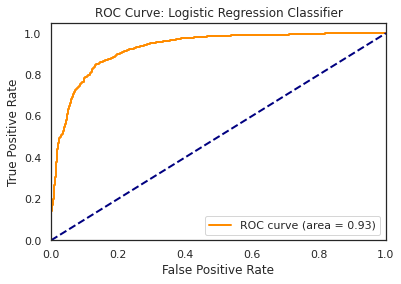

In [54]:
plt.figure()
lw = 2
plt.plot(log_fpr, log_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % log_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression Classifier')
plt.legend(loc="lower right")
plt.show()

**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix: Logistic Regression Classifier')

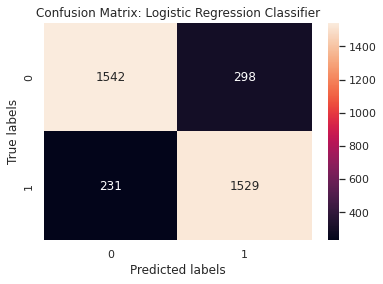

In [55]:
cm = confusion_matrix(y_test, log_y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: Logistic Regression Classifier')

**Top Features:**

In [56]:
log_feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(log_vectorizer.get_feature_names(), log_clf.coef_[0])}

In [57]:
print("Top Positive Features:")
sorted(log_feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top Positive Features:


[('loved', 5.909),
 ('great', 5.783),
 ('enjoyed', 4.705),
 ('love', 3.676),
 ('wonderful', 3.545),
 ('hot', 3.246),
 ('well', 3.226),
 ('excellent', 2.847),
 ('good', 2.695),
 ('read', 2.599)]

In [58]:
print("Top Non-Positive Features:")
sorted(log_feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top Non-Positive Features:


[('not', -5.016),
 ('okay', -3.918),
 ('ok', -3.814),
 ('boring', -3.502),
 ('nothing', -3.386),
 ('bad', -3.233),
 ('waste', -3.075),
 ('sex', -2.987),
 ('free', -2.801),
 ('finish', -2.77)]

**Error Analysis:** We check the samples where the model fails to predict its true sentiment. 

In [59]:
log_df_test = pd.concat([X_test, y_test], axis=1)
log_df_test['pred_label'] = log_y_pred_test
log_df_test.head(3)

,cleaned_review,label,pred_label
1935,A fun read This book recommended I actually liked If looking suspense book like killing time book figure happens next,1,1
6494,Not well known today readers old character When I child parents loved stories made several movies course I thought boring old fashioned Well still old fashioned comforting old world way The stories set British Isles part WWI WWII Bulldog Drummond makes habit saving damsel distress flair dash There bad language course innuendo explicit sex violence interesting narrative story lines Great quiet rainy Sunday,0,1
1720,best series still good reviewers slammed book enjoyed best series would still recommend reading,1,1


In [60]:
log_error = log_df_test[log_df_test['label'] != log_df_test['pred_label']]
log_error.shape # 535 errors out of 3600 test samples

(529, 3)

In [61]:
log_error.head(3)

,cleaned_review,label,pred_label
6494,Not well known today readers old character When I child parents loved stories made several movies course I thought boring old fashioned Well still old fashioned comforting old world way The stories set British Isles part WWI WWII Bulldog Drummond makes habit saving damsel distress flair dash There bad language course innuendo explicit sex violence interesting narrative story lines Great quiet rainy Sunday,0,1
8128,The Heat Knight The author listed erotica however middle road erotica Not light erotica heavy erotica Basically lord family butlers daughter Christiana They liked younger However something happens never acknowledge fell Years later father dies Lord Beckett makes come work house protect Beckett still love wants forget happen years ago Christiana want work castle Some people mean wants get away feeling Beckett womanizing ways Christiana seems give easily becoming Beckett mistress decent short story A big misunderstanding almost costs happiness long couple things But always things work end Short story short really develop great story lot say Will come whether like erotic,1,0
10557,Not thing wrong one Top notch funny shifter romance My first author already picked another Sexy alphas wow Sheri funny Not one miss get ready good laugh steamy,1,0


Our first model is the **logistic regression classifier model** with the best parameters combination from our GridSearchCV. The classification table and AUC score show good performance of the model. Our top positive and negative features give insights into how the model works. All top positive feature words like *love*, *great*, *enjoy*, *wonderful*, *excellent* have positive conntotation. Likewise most words in the negatuive top feature have negative connotation— which is a good sign! When we do our error analysis, we see that the model mostly fails on classifying the 3 star reviews because the ratings are very subjective. A 3 star may be good for someone and bad for others. So, we see a mix of positive and negative words in our erroneous reviews which confuses the model. For instance in the first review of the above error analysis dataframe we can see that we have words like *great* and *bad* in the same review. 


### Multinomial Naive Bayes Classifier

First we fit CountVectorizer on entire data for more robust vocabulary, then transform them to both train and test set. Then, we train our classifier model and make predictions on our test set. 

In [62]:
nb_vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords, max_df=0.8, min_df=1, ngram_range=(1,2))
nb_fit = nb_vectorizer.fit(X)
nb_X_train = nb_fit.transform(X_train)
nb_X_test = nb_fit.transform(X_test)

In [63]:
nb_clf = MultinomialNB()
nb_clf.fit(nb_X_train, y_train)

MultinomialNB()

In [64]:
# make prediction on testing data
nb_y_pred_test = nb_clf.predict(nb_X_test)
# check the predicted probabilities on each test data
nb_y_predprob_test = nb_clf.predict_proba(nb_X_test)

**Classification Report**

In [65]:
print(classification_report(y_test, nb_y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1840
           1       0.84      0.86      0.85      1760

    accuracy                           0.85      3600
   macro avg       0.85      0.85      0.85      3600
weighted avg       0.85      0.85      0.85      3600



**ROC Curve and AUC Score**

In [66]:
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_true = y_test, y_score = nb_y_predprob_test[:,1], pos_label=1)
nb_roc_auc = auc(nb_fpr, nb_tpr) # area under ROC curve

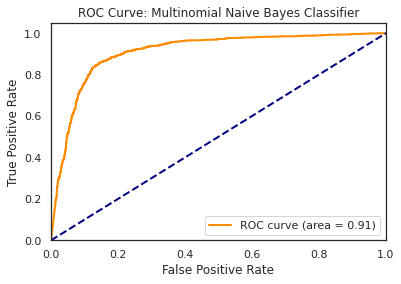

In [67]:
plt.figure()
lw = 2
plt.plot(nb_fpr, nb_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Multinomial Naive Bayes Classifier')
plt.legend(loc="lower right")
plt.show()

**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix: Multinomial Naive Bayes Classifier')

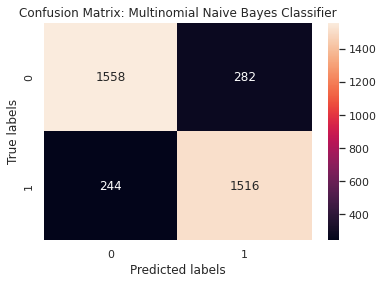

In [68]:
cm = confusion_matrix(y_test, nb_y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: Multinomial Naive Bayes Classifier')

**Top Features:**

In [69]:
nb_feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(nb_vectorizer.get_feature_names(), nb_clf.coef_[0])}

In [70]:
print("Top Positive Features:")
sorted(nb_feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top Positive Features:


[('book', -5.413),
 ('read', -5.534),
 ('story', -5.554),
 ('one', -6.049),
 ('good', -6.098),
 ('love', -6.211),
 ('great', -6.393),
 ('would', -6.414),
 ('series', -6.425),
 ('characters', -6.436)]

In [71]:
print("Top Non-Positive Features:")
sorted(nb_feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top Non-Positive Features:


[('aa', -13.745),
 ('aa done', -13.745),
 ('aaaaaannnnd', -13.745),
 ('aaaaaannnnd nothing', -13.745),
 ('aaboulet', -13.745),
 ('aand', -13.745),
 ('aand nate', -13.745),
 ('aarggg', -13.745),
 ('aaron', -13.745),
 ('aaron also', -13.745)]

**Error Analysis:** We check the samples where the model fails to predict its true sentiment. 

In [72]:
nb_df_test = pd.concat([X_test, y_test], axis=1)
nb_df_test['pred_label'] = nb_y_pred_test
nb_df_test.head(3)

,cleaned_review,label,pred_label
1935,A fun read This book recommended I actually liked If looking suspense book like killing time book figure happens next,1,1
6494,Not well known today readers old character When I child parents loved stories made several movies course I thought boring old fashioned Well still old fashioned comforting old world way The stories set British Isles part WWI WWII Bulldog Drummond makes habit saving damsel distress flair dash There bad language course innuendo explicit sex violence interesting narrative story lines Great quiet rainy Sunday,0,1
1720,best series still good reviewers slammed book enjoyed best series would still recommend reading,1,1


In [73]:
nb_error = nb_df_test[nb_df_test['label'] != nb_df_test['pred_label']]
nb_error.shape # 540 errors out of 3600 test samples

(526, 3)

In [74]:
nb_error.head(3)

,cleaned_review,label,pred_label
6494,Not well known today readers old character When I child parents loved stories made several movies course I thought boring old fashioned Well still old fashioned comforting old world way The stories set British Isles part WWI WWII Bulldog Drummond makes habit saving damsel distress flair dash There bad language course innuendo explicit sex violence interesting narrative story lines Great quiet rainy Sunday,0,1
4617,Great sci fi story I love book I even halfway thru I ready buy rest series It hard sci fi lot well researched mathematics enough keep hard sci fi fan happy To previous reviewer commented global warming real U S bad guy I get book Yes mentioned global warming turned real U S spend lots money get control I think author preaching either subject It simply small part storyline In fact far mentioned I recommend book sci fi fan,1,0
7238,BOOK PLEASE I actually started reading book least times actually reading cover cover one day I might add In fact I decided start reading nothing else seemed interesting Call reader block On rare ocasions I actually force feed eyes brain I held hope book would break current block I thought What heck read page throughout day finally something hit senses hours later I looking sequel No spoilers Touching love story two people thought set lives futures seeing first time Over extremely short period time come know therefore wanted remember As one learns strength rediscovers hope living tragedy looms head Ms McCay details main characters past discover possible futures little humor thrown pleasure My regret finding sequel I left imagination help decide happens Michael Regina etc This book dated I think time find sacrifices made worth give tale happy ending,1,0


Naïve Bayes classifier is based on the hypothesis that each attribute is mutually independent, thus it is widely used for its easiness and high efficiency. But because of the text redundant features and rough parameter estimation, the performance of Naïve Bayes in text classification tasks is not good and can be seen above.

Our second model is the **multinomial naive bayes classifier model** with the best parameters combination form our GridSearchCV. The classification table and AUC score again show good performance of the model and fairly similar results to before. Our top positive and negative features give insights into how the model works. The top words in both classes are not as good as before, infact, the top negative words are varied and all over the place— hinting that maybe we need to make our deconstruction and cleaning process better.  Even though the results are similar to the logistic regression model from before, we believe Naive Bayes classifier doesn’t do the best job classifying the text. Naive Bayes classifier is based on the hypothesis that each attribute is mutually independent, thus it is widely used for its easiness and high efficiency. But because of the text redundant features and rough parameter estimation, the performance of Naive Bayes in text classification tasks is not good and can be seen here.

### Support Vector Machine Classifier

First we fit CountVectorizer on entire data for more robust vocabulary, then transform them to both train and test set. We then transform both of them to tf-idf representation. Finally, we train our classifier model and make predictions on our test set. 

In [75]:
svm_vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords, max_df=0.8, min_df=5, ngram_range=(1,2))
svm_fit = svm_vectorizer.fit(X)
svm_X_train = svm_fit.transform(X_train)
svm_X_test = svm_fit.transform(X_test)
svm_X_train = tfidf.fit_transform(svm_X_train)
svm_X_test = tfidf.transform(svm_X_test)

In [76]:
svm_clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
svm_clf.fit(svm_X_train, y_train)

SGDClassifier(alpha=0.001, max_iter=5, random_state=42, tol=None)

In [77]:
# make prediction on testing data
svm_y_pred_test = svm_clf.predict(svm_X_test)
# check the predicted probabilities on each test data
svm_y_predprob_test = svm_clf.decision_function(svm_X_test)
svm_y_predprob_test = pd.Series(svm_y_predprob_test)  # convert array from decision function into series

**Classification Report**

In [78]:
print(classification_report(y_test, svm_y_pred_test))

              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1840
           1       0.82      0.88      0.85      1760

    accuracy                           0.85      3600
   macro avg       0.85      0.85      0.85      3600
weighted avg       0.85      0.85      0.85      3600



**ROC Curve and AUC Score**

In [79]:
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_true = y_test, y_score = svm_y_predprob_test, pos_label=1)
svm_roc_auc = auc(svm_fpr, svm_tpr) # area under ROC curve

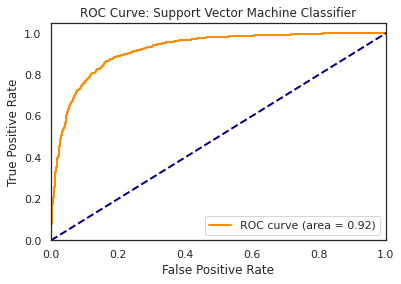

In [80]:
plt.figure()
lw = 2
plt.plot(svm_fpr, svm_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Support Vector Machine Classifier')
plt.legend(loc="lower right")
plt.show()

**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix: Support Vector Machine Classifier')

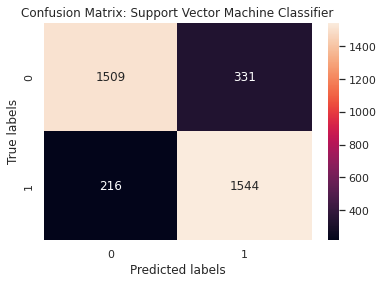

In [81]:
cm = confusion_matrix(y_test, svm_y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: Support Vector Machine Classifier')

**Top Features:**

In [82]:
svm_feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(svm_vectorizer.get_feature_names(), svm_clf.coef_[0])}

In [83]:
print("Top Positive Features:")
sorted(svm_feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top Positive Features:


[('great', 2.863),
 ('loved', 2.69),
 ('enjoyed', 2.409),
 ('love', 2.111),
 ('hot', 1.639),
 ('well', 1.623),
 ('wonderful', 1.62),
 ('read', 1.577),
 ('series', 1.556),
 ('good', 1.508)]

In [84]:
print("Top Non-Positive Features:")
sorted(svm_feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top Non-Positive Features:


[('not', -2.775),
 ('ok', -2.063),
 ('bad', -1.87),
 ('okay', -1.793),
 ('sex', -1.598),
 ('boring', -1.596),
 ('nothing', -1.57),
 ('like', -1.56),
 ('free', -1.519),
 ('book', -1.408)]

**Error Analysis:** We check the samples where the model fails to predict its true sentiment. 

In [85]:
svm_df_test = pd.concat([X_test, y_test], axis=1)
svm_df_test['pred_label'] = svm_y_pred_test
svm_df_test.head(3)

,cleaned_review,label,pred_label
1935,A fun read This book recommended I actually liked If looking suspense book like killing time book figure happens next,1,1
6494,Not well known today readers old character When I child parents loved stories made several movies course I thought boring old fashioned Well still old fashioned comforting old world way The stories set British Isles part WWI WWII Bulldog Drummond makes habit saving damsel distress flair dash There bad language course innuendo explicit sex violence interesting narrative story lines Great quiet rainy Sunday,0,1
1720,best series still good reviewers slammed book enjoyed best series would still recommend reading,1,1


In [86]:
svm_error = svm_df_test[svm_df_test['label'] != svm_df_test['pred_label']]
svm_error.shape # 563 errors out of 3600 test samples

(547, 3)

In [87]:
svm_error.head(3)

,cleaned_review,label,pred_label
6494,Not well known today readers old character When I child parents loved stories made several movies course I thought boring old fashioned Well still old fashioned comforting old world way The stories set British Isles part WWI WWII Bulldog Drummond makes habit saving damsel distress flair dash There bad language course innuendo explicit sex violence interesting narrative story lines Great quiet rainy Sunday,0,1
8128,The Heat Knight The author listed erotica however middle road erotica Not light erotica heavy erotica Basically lord family butlers daughter Christiana They liked younger However something happens never acknowledge fell Years later father dies Lord Beckett makes come work house protect Beckett still love wants forget happen years ago Christiana want work castle Some people mean wants get away feeling Beckett womanizing ways Christiana seems give easily becoming Beckett mistress decent short story A big misunderstanding almost costs happiness long couple things But always things work end Short story short really develop great story lot say Will come whether like erotic,1,0
10557,Not thing wrong one Top notch funny shifter romance My first author already picked another Sexy alphas wow Sheri funny Not one miss get ready good laugh steamy,1,0


Our last model is the **support vector machine classifier model** with the best parameters combination from our GridSearchCV.  The classification table and AUC score show good performance of the model like from the 2 previous models. Our top positive and negative features give insights into how the model works. All top positive feature words like *love*, *great*, *enjoy*, *enjoyed* have positive conntotation. Likewise, words in the negatuive top feature are *bad*, *boring* etc. which have negative connotation— again a good sign!. Like our logistic regression model, when we do our error analysis, we see that the model mostly fails on classifying the neutral types of reviews. We see a mix of positive and negative words in our erroneous reviews which confuses the model. 

## Evaluation Summary

In [89]:
score_summary = {'Model Type':  ['Logistic Regression Classifier', 'Multinomial Naive Bayes Classifier', 'Support Vector Machine Classifier'],
        'F1-Score': ['0: 0.85, 1: 0.85', '0: 0.86, 1: 0.85', '0: 0.85 , 1: 0.85'],
        'AUC Metric': ['0.93','0.91','0.92']}
summary = pd.DataFrame(score_summary, index=[1,2,3])
summary

,Model Type,F1-Score,AUC Metric
1,Logistic Regression Classifier,"0: 0.85, 1: 0.85",0.93
2,Multinomial Naive Bayes Classifier,"0: 0.86, 1: 0.85",0.91
3,Support Vector Machine Classifier,"0: 0.85 , 1: 0.85",0.92


## Conclusion
With the above project, we built 3 binary sentiment classifier models for Amazon Kindle Book Reviews Dataset. The 3 models used were a Logistic Regression Classifier, a Multinomial NB Classifier and a Support Vector Classifier. The following was the pipeline of our project:<br>

- **Data Preprocessing**: We first explored and cleaned the data. We also balanced our data and explored word clouds and n-gram plots.<br> 

- **Model Selection and Parameter Tuning**: We then built 3 pipelines and used GridSearchCV to explore the best parameter settings for CountVectorizer the respective model
.
- **Model Training and Evaluation**: We then split the data into 70% training and 30% testing sets. We transformed our data using CountVectorizer and Tfidf Transformer. Then, we trained the 3 respective classifier models on the training data (with the best parameter setting). Finally, we we evaluated our 3 modes'' performance on the testing data using classification report, ROC curve, confusion matrix. 

- **Model Explanation and Error Analysis**: Finally, we checked the top coefficient words to explain the model performance and conducted an error analysis by explaining samples where the model(s) made errors.

Overall, all models work great and around the same ball park (**F1 score: approx.0.85, AUC score: approx. 0.92**). However, we would strongly advise the use of logistic regression classifier or a SVM classifier over a multinomial NB classifier for text classifications based on our analysis and evaluations. 

Future avenues for this project could be better deconstruction and cleaning of our data. No matter how much we try tuning our models, we should heavily focus on a data-centric approach of first making our data good rather than an AI-centric approach of fine-tuning our models. This is because our model can only be as good as our data is. 

